# TransKal Pluggable Fault Detector

This notebook creates a pluggable fault detector using the trained TransKal model.

**Scenario**: Sequential fault injection with 8h normal, then 17 faults (1h on, 1h off each).

**Evaluation Dataset**: Pre-generated trajectory from notebook 04.

## Configuration & Imports

In [1]:
import os
import json
import time
from pathlib import Path
from dataclasses import dataclass
from typing import List, Tuple, Dict, Any

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, balanced_accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

DATA_DIR = Path('../data')
MODEL_DIR = Path('../outputs/models')
METRICS_DIR = Path('../outputs/metrics')
FIGURES_DIR = Path('../outputs/figures')

METRICS_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

QUICK_MODE = False
if (DATA_DIR / 'detector_trajectory_quick.csv').exists():
    if not (DATA_DIR / 'detector_trajectory.csv').exists():
        QUICK_MODE = True
    else:
        quick_mtime = (DATA_DIR / 'detector_trajectory_quick.csv').stat().st_mtime
        full_mtime = (DATA_DIR / 'detector_trajectory.csv').stat().st_mtime
        QUICK_MODE = quick_mtime > full_mtime

if os.environ.get('QUICK_MODE', '').lower() in ('true', '1', 'yes'):
    QUICK_MODE = True

FILE_SUFFIX = '_quick' if QUICK_MODE else ''

print('='*60)
print('TransKal Pluggable Fault Detector')
if QUICK_MODE:
    print('QUICK MODE - Using short trajectory')
print(f'Device: {device}')
print('='*60)

TransKal Pluggable Fault Detector
Device: cuda


## Define Model Architecture

In [2]:
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))
        
    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

class TransformerClassifier(nn.Module):
    """Transformer classifier for time series (matches 24-transkal-final-training.ipynb)."""
    def __init__(self, input_dim, num_classes, d_model=32, nhead=2, 
                 num_layers=1, dropout=0.3):
        super().__init__()
        self.d_model = d_model
        
        self.embedding = nn.Sequential(
            nn.Linear(input_dim, d_model),
            nn.LayerNorm(d_model),
            nn.Dropout(dropout)
        )
        
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, 
            dim_feedforward=d_model * 2,
            dropout=dropout, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        self.classifier = nn.Sequential(
            nn.Linear(d_model, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, num_classes)
        )
        
    def forward(self, x):
        x = self.embedding(x) * np.sqrt(self.d_model)
        x = self.pos_encoder(x)
        x = self.transformer(x)
        x = x.mean(dim=1)
        return self.classifier(x)

class KalmanFilter:
    """Adaptive Kalman filter for smoothing predictions within a single run."""
    def __init__(self, num_classes, Q=1e-5, R=0.1):
        self.num_classes = num_classes
        self.Q_base = Q
        self.R_base = R
        self.transition_threshold = 0.25
        self.confidence_threshold = 0.65
        self.stabilization_steps = 3
        self.vote_window = 5
        self.reset()
        
    def reset(self):
        self.x_est = None
        self.P = None
        self.steps_since_transition = 100
        self.prev_class = None
        self.prob_history = []
        
    def _compute_entropy(self, probs):
        probs = np.clip(probs, 1e-10, 1.0)
        entropy = -np.sum(probs * np.log(probs))
        max_entropy = np.log(len(probs))
        return entropy / max_entropy if max_entropy > 0 else 0
    
    def _detect_transition(self, prev_state, curr_obs, prev_class, curr_class):
        if curr_class == prev_class:
            return False
        curr_conf = np.max(curr_obs)
        prev_class_drop = prev_state[prev_class] - curr_obs[prev_class]
        prob_change = np.abs(curr_obs - prev_state).max()
        if curr_conf > self.confidence_threshold and prev_class_drop > 0.15:
            return True
        if prob_change > self.transition_threshold and curr_conf > 0.5:
            return True
        return False
        
    def update(self, observation):
        probs = np.array(observation).flatten()
        probs = np.clip(probs, 1e-10, 1.0)
        probs = probs / probs.sum()
        
        self.prob_history.append(probs.copy())
        if len(self.prob_history) > self.vote_window:
            self.prob_history.pop(0)
        
        curr_class = np.argmax(probs)
        
        if self.x_est is None:
            self.x_est = probs.copy()
            self.P = np.eye(self.num_classes) * 0.1
            self.prev_class = curr_class
            return self.x_est
        
        if self._detect_transition(self.x_est, probs, self.prev_class, curr_class):
            self.x_est = probs.copy()
            self.P = np.eye(self.num_classes) * 0.1
            self.steps_since_transition = 0
            self.prev_class = curr_class
            return self.x_est
        
        entropy = self._compute_entropy(probs)
        transition_factor = min(1.0, self.steps_since_transition / self.stabilization_steps)
        confidence = np.max(probs)
        
        Q = self.Q_base * (1 + 4 * entropy) * (2 - transition_factor)
        R = self.R_base * (1 - confidence + entropy) * transition_factor
        
        x_pred = self.x_est.copy()
        P_pred = self.P + Q * np.eye(self.num_classes)
        
        H = np.eye(self.num_classes)
        S = P_pred + R * np.eye(self.num_classes)
        K = P_pred @ np.linalg.inv(S)
        
        self.x_est = x_pred + K @ (probs - x_pred)
        self.x_est = np.clip(self.x_est, 0, 1)
        self.x_est = self.x_est / self.x_est.sum()
        
        self.P = (np.eye(self.num_classes) - K @ H) @ P_pred
        self.steps_since_transition += 1
        self.prev_class = np.argmax(self.x_est)
        
        return self.x_est

print('Model and Kalman filter classes defined')

Model and Kalman filter classes defined


## Load Trained Model

In [3]:
print('\n[Step 1/5] Loading trained TransKal model...')

model_path = MODEL_DIR / 'transkal_final.pt'
model_data = torch.load(model_path, map_location=device, weights_only=False)

config = model_data['model_config']
features = model_data['features']
label_classes = model_data['label_encoder_classes']
scaler_mean = model_data['scaler_mean']
scaler_scale = model_data['scaler_scale']
kalman_params = model_data.get('kalman_params', {'Q': 1e-5, 'R': 0.1})

num_classes = len(label_classes)
class_to_idx = {c: i for i, c in enumerate(label_classes)}
idx_to_class = {i: c for i, c in enumerate(label_classes)}

model = TransformerClassifier(
    input_dim=config['input_dim'],
    num_classes=num_classes,
    d_model=config['d_model'],
    nhead=config['nhead'],
    num_layers=config['num_layers'],
    dropout=config['dropout']
)
model.load_state_dict(model_data['model_state_dict'])
model.to(device)
model.eval()

# Initialize Kalman filter with trained parameters
kalman = KalmanFilter(num_classes, Q=kalman_params['Q'], R=kalman_params['R'])

print(f'Model loaded from {model_path}')
print(f'  Features: {len(features)}')
print(f'  Classes: {num_classes}')
print(f'  Kalman Q: {kalman_params["Q"]:.2e}, R: {kalman_params["R"]:.4f}')


[Step 1/5] Loading trained TransKal model...


Model loaded from ../outputs/models/transkal_final.pt
  Features: 52
  Classes: 18
  Kalman Q: 5.04e-05, R: 0.0223


## Create Detector

In [4]:
@dataclass
class DetectionResult:
    fault_class: int
    confidence: float
    step: int
    alternatives: List[Tuple[int, float]]
    statistics: Dict[str, Any]

class SequenceBuffer:
    def __init__(self, seq_len, n_features, scaler_mean, scaler_scale):
        self.seq_len = seq_len
        self.buffer = np.zeros((seq_len, n_features), dtype=np.float32)
        self.scaler_mean = scaler_mean
        self.scaler_scale = scaler_scale
        self.count = 0

    def add(self, features):
        self.buffer = np.roll(self.buffer, -1, axis=0)
        self.buffer[-1] = (features - self.scaler_mean) / self.scaler_scale
        self.count += 1

    def is_ready(self):
        return self.count >= self.seq_len

    def get_sequence(self):
        return self.buffer.copy()

print('Detector classes defined')

Detector classes defined


## Load Trajectory

In [5]:
print('\n[Step 2/5] Loading pre-generated trajectory...')

traj_file = DATA_DIR / f'detector_trajectory{FILE_SUFFIX}.csv'
traj_df = pd.read_csv(traj_file)

info_file = DATA_DIR / f'detector_trajectory{FILE_SUFFIX}_info.json'
with open(info_file) as f:
    traj_info = json.load(f)

FAULT_CLASSES = traj_info['fault_classes']
RECORD_INTERVAL = traj_info['record_interval_seconds']

print(f'Loaded trajectory: {len(traj_df)} samples, {traj_info["total_hours"]} hours')
print(f'Faults: {len(FAULT_CLASSES)}')


[Step 2/5] Loading pre-generated trajectory...
Loaded trajectory: 875 samples, 42 hours
Faults: 17


## Run Detection

In [6]:
print('\n[Step 3/5] Running fault detection...')
detect_start = time.time()

seq_len = config['sequence_length']
xmeas_cols = [f'xmeas_{i}' for i in range(1, 42)]
xmv_cols = [f'xmv_{i}' for i in range(1, 12)]
feature_cols = xmeas_cols + xmv_cols

buffer = SequenceBuffer(seq_len, len(features), scaler_mean, scaler_scale)

detections = []
for idx, row in traj_df.iterrows():
    feat = row[feature_cols].values.astype(np.float32)
    buffer.add(feat)
    
    if buffer.is_ready():
        seq = torch.tensor(buffer.get_sequence()).unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(seq)
            probs = torch.softmax(output, dim=1).cpu().numpy()[0]
        
        pred_idx = probs.argmax()
        pred_class = int(idx_to_class[pred_idx])
        confidence = float(probs.max())
        
        top3 = np.argsort(probs)[::-1][:3]
        alternatives = [(int(idx_to_class[i]), float(probs[i])) for i in top3]
    else:
        pred_class = 0
        confidence = 0.0
        alternatives = []
    
    detections.append({
        'step': int(row['step']),
        'time_hours': row['time_hours'],
        'predicted_class': pred_class,
        'confidence': confidence,
        'true_class': int(row['faultNumber'])
    })

detections_df = pd.DataFrame(detections)
detections_df['correct'] = detections_df['predicted_class'] == detections_df['true_class']

print(f'Detection complete in {time.time() - detect_start:.2f}s')
print(f'  Samples: {len(detections_df)}')
print(f'  Accuracy: {detections_df["correct"].mean():.4f}')


[Step 3/5] Running fault detection...


Detection complete in 1.24s
  Samples: 875
  Accuracy: 0.1326


## Compute Metrics

In [7]:
print('\n[Step 4/5] Computing metrics...')

y_true = detections_df['true_class'].values
y_pred = detections_df['predicted_class'].values

overall_accuracy = accuracy_score(y_true, y_pred)
balanced_acc = balanced_accuracy_score(y_true, y_pred)
f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)
f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)

y_true_binary = (y_true != 0).astype(int)
y_pred_binary = (y_pred != 0).astype(int)
fault_det_acc = accuracy_score(y_true_binary, y_pred_binary)
fault_det_recall = recall_score(y_true_binary, y_pred_binary, zero_division=0)

print('\nOverall Performance:')
print('='*50)
print(f'Multiclass Accuracy: {overall_accuracy:.4f}')
print(f'Balanced Accuracy: {balanced_acc:.4f}')
print(f'F1 (weighted): {f1_weighted:.4f}')
print(f'F1 (macro): {f1_macro:.4f}')
print(f'Fault Detection Recall: {fault_det_recall:.4f}')
print('='*50)


[Step 4/5] Computing metrics...

Overall Performance:
Multiclass Accuracy: 0.1326
Balanced Accuracy: 0.2079
F1 (weighted): 0.1286
F1 (macro): 0.1135
Fault Detection Recall: 1.0000


## Visualizations

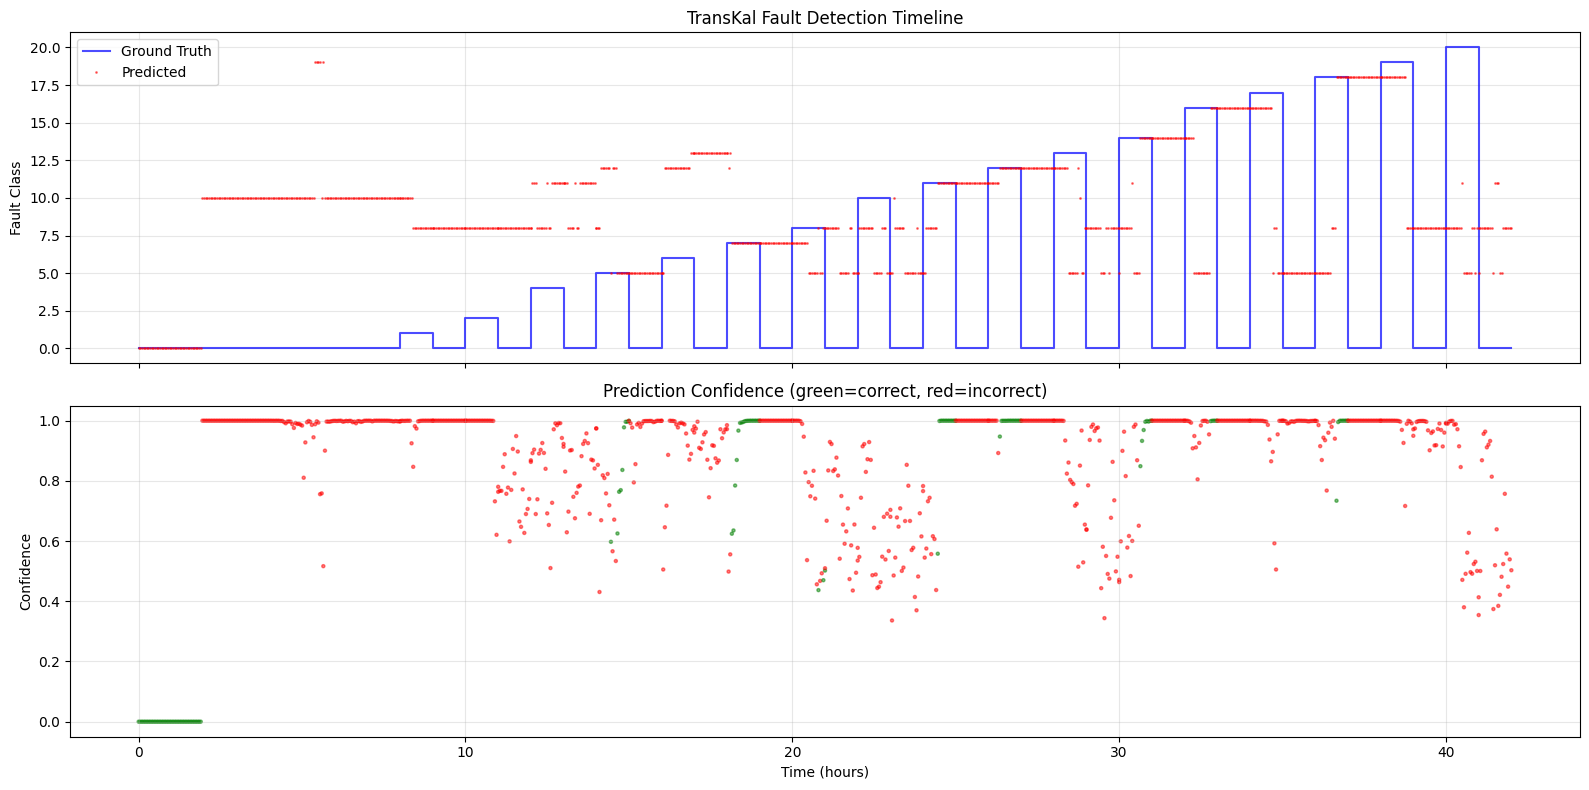

Saved to ../outputs/figures/transkal_detector_timeline.png


In [8]:
fig, axes = plt.subplots(2, 1, figsize=(16, 8), sharex=True)

time_h = detections_df['time_hours'].values

ax = axes[0]
ax.plot(time_h, detections_df['true_class'], 'b-', linewidth=1.5, label='Ground Truth', alpha=0.7)
ax.plot(time_h, detections_df['predicted_class'], 'r.', markersize=2, label='Predicted', alpha=0.5)
ax.set_ylabel('Fault Class')
ax.set_title('TransKal Fault Detection Timeline')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[1]
colors = ['green' if c else 'red' for c in detections_df['correct']]
ax.scatter(time_h, detections_df['confidence'], c=colors, s=5, alpha=0.5)
ax.set_ylabel('Confidence')
ax.set_xlabel('Time (hours)')
ax.set_title('Prediction Confidence (green=correct, red=incorrect)')
ax.grid(True, alpha=0.3)

plt.tight_layout()
output_file = FIGURES_DIR / f'transkal_detector_timeline{FILE_SUFFIX}.png'
plt.savefig(output_file, dpi=150, bbox_inches='tight')
plt.show()
print(f'Saved to {output_file}')

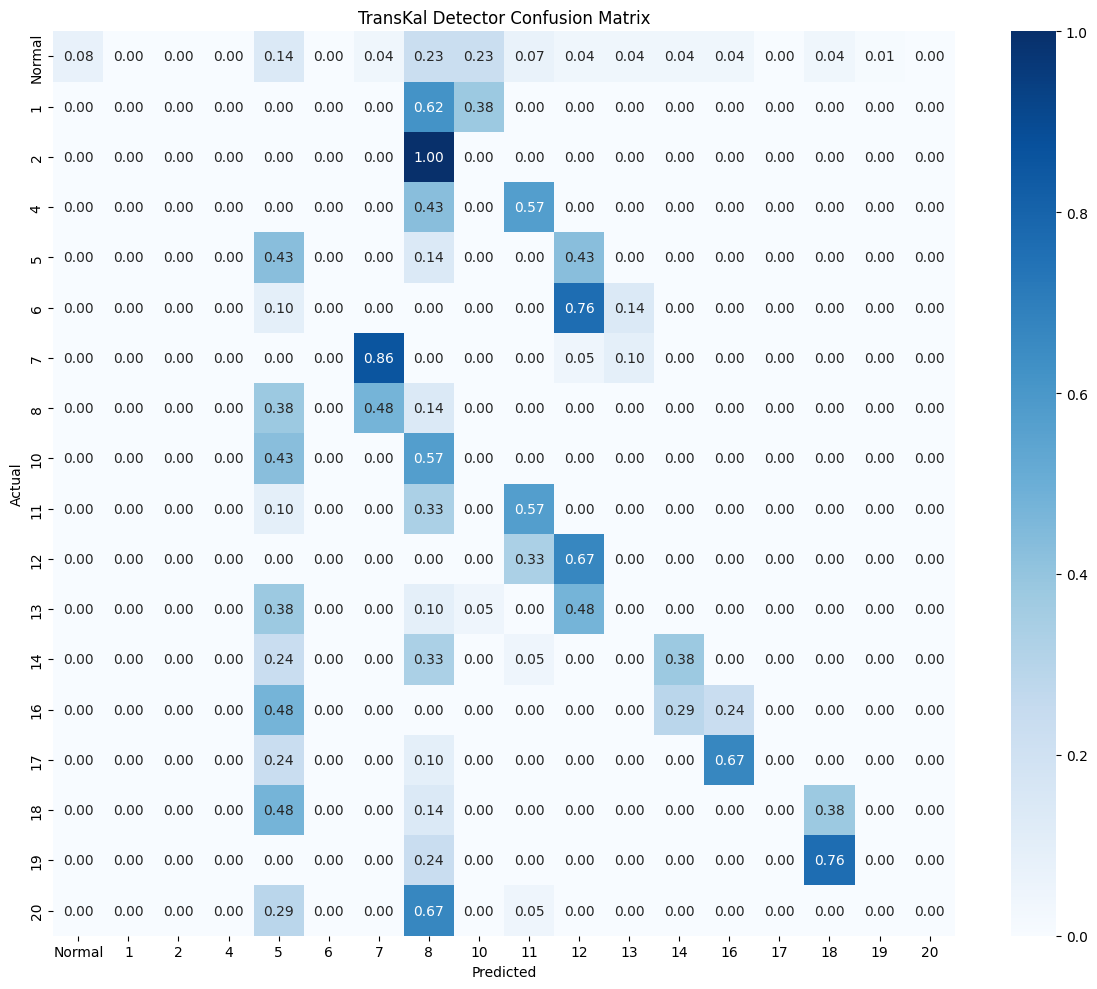

Saved to ../outputs/figures/transkal_detector_confusion_matrix.png


In [9]:
all_classes = sorted(set(y_true) | set(y_pred))
class_labels = ['Normal' if c == 0 else str(int(c)) for c in all_classes]

cm = confusion_matrix(y_true, y_pred, labels=all_classes)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels, ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('TransKal Detector Confusion Matrix')

plt.tight_layout()
output_file = FIGURES_DIR / f'transkal_detector_confusion_matrix{FILE_SUFFIX}.png'
plt.savefig(output_file, dpi=150, bbox_inches='tight')
plt.show()
print(f'Saved to {output_file}')

## Save Results

In [10]:
print('\n[Step 5/5] Saving results...')

results = {
    'model': 'TransKal',
    'detector_type': 'pluggable',
    'quick_mode': QUICK_MODE,
    'simulation': {
        'total_hours': traj_info['total_hours'],
        'total_samples': len(detections_df),
        'faults_tested': FAULT_CLASSES
    },
    'overall_metrics': {
        'accuracy': float(overall_accuracy),
        'balanced_accuracy': float(balanced_acc),
        'f1_weighted': float(f1_weighted),
        'f1_macro': float(f1_macro),
        'fault_detection_recall': float(fault_det_recall)
    }
}

output_file = METRICS_DIR / f'transkal_detector_results{FILE_SUFFIX}.json'
with open(output_file, 'w') as f:
    json.dump(results, f, indent=2)
print(f'Saved to {output_file}')


[Step 5/5] Saving results...
Saved to ../outputs/metrics/transkal_detector_results.json


In [11]:
print('\n' + '='*60)
print('TransKal Pluggable Detector Complete!')
if QUICK_MODE:
    print('(Quick mode)')
print('='*60)
print(f'\nAccuracy: {overall_accuracy:.4f}')
print(f'F1 (weighted): {f1_weighted:.4f}')
print(f'Fault Detection Recall: {fault_det_recall:.4f}')
print('='*60)


TransKal Pluggable Detector Complete!

Accuracy: 0.1326
F1 (weighted): 0.1286
Fault Detection Recall: 1.0000
